In [13]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import utils

In [3]:
scenarios = []
for gre in [i/100 for i in list(range(2, 10))]:
    for gs in [i/100 for i in list(range(2, 10))]:
        for ps in [100]:
            for ma in list(range(0, 20001, 5000)):
                for ia in list(range(0, 20001, 5000)):
                    scenarios.append(utils.Scenario(utils.RealEstate(4.2e6,
                                                                     utils.Mortgage(0.0305, 3.6e6, 30, 12)),
                                                    utils.Portfolio(), gre, gs, ps, ma, ia))


sim = utils.Simulation(scenarios)

In [4]:
%%time
sim.simulate()

Completed scenario 1599.
CPU times: user 1min 24s, sys: 30.6 s, total: 1min 54s
Wall time: 1min 52s


In [5]:
history = sim.history
totals = sim.profit

## Historical Market Development
Let's first calculate the historical annual appreciation for real estate in Norway and the S&P500.

In [6]:
real_estate_price_15_y = 73339
real_estate_price_0_y = 27308
snp500_price_15_y = 3235
snp500_price_0_y = 1186
hist_growth_rate_real_estate = math.pow(real_estate_price_15_y/real_estate_price_0_y, 1/15) - 1
hist_growth_rate_snp500 = math.pow(snp500_price_15_y/snp500_price_0_y, 1/15) - 1
print(f'Annual growth rate real estate for the last 15 years: {hist_growth_rate_real_estate:.2%}, '
      f'annual growth rate S&P500 for the last 15 years: {hist_growth_rate_snp500:.2%}.')

Annual growth rate real estate for the last 15 years: 6.81%, annual growth rate S&P500 for the last 15 years: 6.92%.


## Real Estate Profit At Various Overpayment Levels
Here, we fix the annual real estate growth rate to its historic levels and compare the real estate profit for various overpayment amounts.

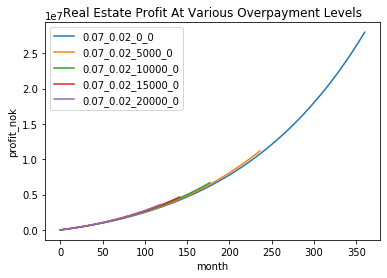

In [7]:
to_plot = history[(history.growth_rate_real_estate==round(hist_growth_rate_real_estate, 2))
                  & (history.growth_rate_stocks==history.growth_rate_stocks.min())
                  & (history.investment_amount==0)]

for scenario in to_plot.scenario_name.unique():
    subplot = history[history.scenario_name==scenario]
    plt.plot(subplot.month, subplot.current_profit_real_estate, label=scenario)

plt.legend()
plt.xlabel('month')
plt.ylabel('profit_nok')
plt.title('Real Estate Profit At Various Overpayment Levels')
plt.show()

As we can see, the overpayment amount influences primarily the number of payment terms. However, the profit is primarily influenced by time. This means that the compounding effect of the annual growth in the real estate market overpowers the reduction of expenses by paying less interest.

## Real Estate Profit At Various Growth Levels With No Overpayment
We will now fix the overpayment to 0 and explore the real estate profit at various annual real estate growth levels.

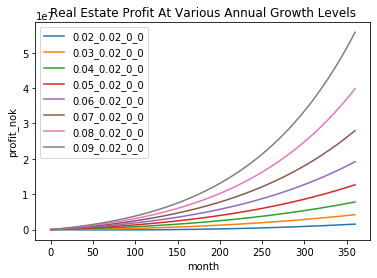

In [8]:
to_plot = history[(history.mortgage_overpayment_amount==0)
                  & (history.growth_rate_stocks==history.growth_rate_stocks.min())
                  & (history.investment_amount==0)]

for scenario in to_plot.scenario_name.unique():
    subplot = history[history.scenario_name==scenario]
    plt.plot(subplot.month, subplot.current_profit_real_estate, label=scenario)

plt.legend()
plt.xlabel('month')
plt.ylabel('profit_nok')
plt.title('Real Estate Profit At Various Annual Growth Levels')
plt.show()

As expected, the real estate market grwoth rate has a significant influence on the real estate profit. If we extrapulate using the historic annual growth rates for the last 15 years, the expected profit is 2.8 MLN NOK in 30 years (without any mortgage overpayment).

## Real Estate And Stock Profit At Various Growth Rates
Here we look at scenarios where the mortgage overpayment amount equals the investment amount in stocks. However the annual growth rates for stocks and the real estate market may differ. In addition, we are looking at the profit in 12 months.

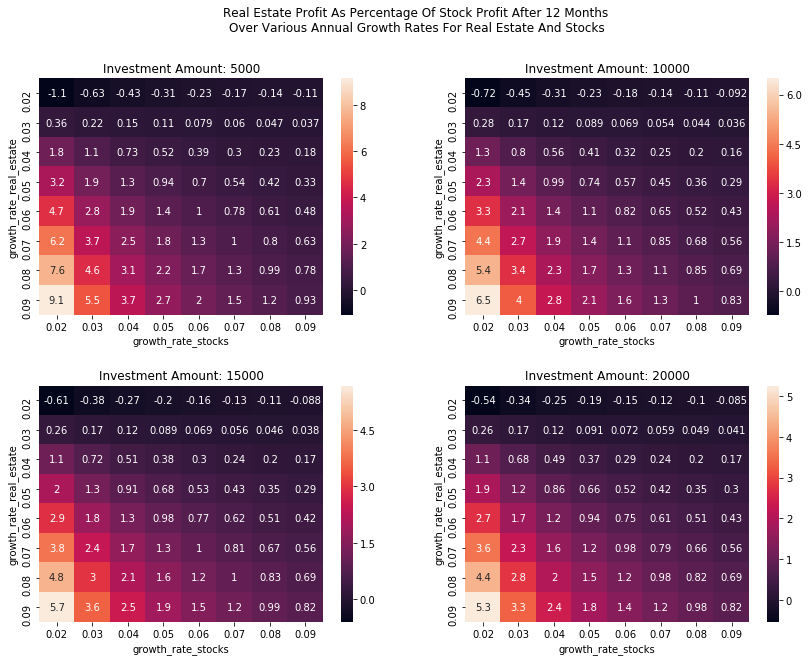

In [9]:
n_months = 12
fig = plt.figure(figsize=(14, 10))
for i, amount in enumerate(list(range(5000, 20001, 5000))):
    to_plot = history[(history.mortgage_overpayment_amount==amount)
                  & (history.investment_amount==amount)
                  & (history.month==n_months)].copy()

    ax = plt.subplot(2, 2, i+1)
    to_plot_pivot = pd.pivot_table(data=to_plot,
                                   index='growth_rate_real_estate',
                                   columns='growth_rate_stocks',
                                   values='profit_ratio')
    sns.heatmap(to_plot_pivot, annot=True)
    plt.title(f'Investment Amount: {amount}')
plt.suptitle(f'Real Estate Profit As Percentage Of Stock Profit After {n_months} Months \nOver Various Annual Growth Rates For Real Estate And Stocks')
plt.subplots_adjust(hspace=0.3)
plt.show()

As we expect, higher real estate market growth leads to higher real estate profit and vice versa. However, there are certain cases where even lower stock market growth outperforms a slightly higher one. For example, at an investment of 20000 NOK per month, at real estate market growth of 3% and stock market growth rate of 2%, the real estate profit is only 26% that of the investment profit.

## Profit Ratio Over Equal Investment Levels And Growth Rates
Here we look at scenarios where the real estate grwoth rate equals the stock market growth rate and the mortgage overpayment equals the stock investment amount. We will plot the profitability ratio over time.

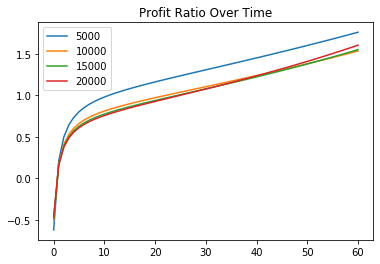

In [10]:
to_plot = history[(history.growth_rate_real_estate==history.growth_rate_stocks)
                  & (history.mortgage_overpayment_amount==history.investment_amount)
                  & (history.investment_amount>0)
                  & (history.growth_rate_stocks==round(hist_growth_rate_real_estate, 2))
                  & (history.month<=60)].copy()

for amount in to_plot.investment_amount.unique():
    subplot = to_plot[to_plot.investment_amount==amount]
    plt.plot(subplot.month, subplot.profit_ratio, label=amount)
plt.legend()
plt.title('Profit Ratio Over Time')
plt.show()

At equal investment / overpayment levels and equal annual growth rates, stocks outperform real estate in the first year. However after a year and a half, in the scenario with smallest investment, real estate outperforms stocks. For all other scenarios (where the investment amount is more or equal to 10000 NOK), real estate starts outperforming the investment after 3 years.

## Equal Growth Rate, No Overpayment, Maximum Investment
Here we look at scenarios where the growth rates are equal to the historic ones, there is no mortgage overpayment and the investment is set to its maximum of 20000 NOK.

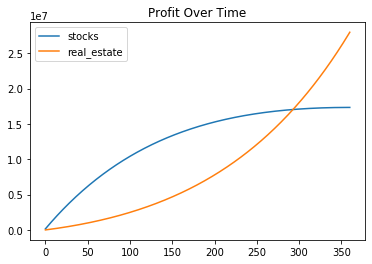

In [11]:
to_plot = history[(history.growth_rate_real_estate==round(hist_growth_rate_real_estate, 2))
                  & (history.mortgage_overpayment_amount==0)
                  & (history.investment_amount==2e4)
                  & (history.growth_rate_stocks==round(hist_growth_rate_snp500, 2))].copy()

plt.plot(to_plot.month, to_plot.cumulative_profit_stocks, label='stocks')
plt.plot(to_plot.month, to_plot.current_profit_real_estate, label='real_estate')

plt.legend()
plt.title('Profit Over Time')
plt.show()

As we can see, with a maximum investment level and no mortgage overpayment, the stock investment strongly outperforms the real estate investment in the first 15 years. After that, the investment amount's value diminishes compared to the inreased price index. In the second half of the mortgage annuity, the real estate keeps compounding and eventually outperforms the stocks at year 23. There are two events that influence this development, namely:
* The real estate investment is made in bulk at the beginning;
* The interest payments diminish as the principal gets repaid;
Becasue of these, the real estate keeps increasing in value as the principal gets repaid and as the real estate market keeps compounding over the years.

## Equal Growth Rate Various Overpayment And Investment Amounts
Here we look at equal growth rates and various overpayment and investment amounts.

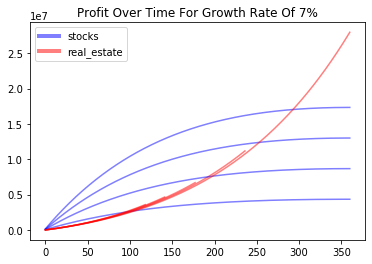

In [19]:
to_plot = history[(history.growth_rate_real_estate==history.growth_rate_stocks)
                  & (history.growth_rate_stocks==round(hist_growth_rate_real_estate, 2))].copy()

for amount in list(range(5000, 20001, 5000)):
    subplot_1 = to_plot[(to_plot.investment_amount==amount) & (to_plot.mortgage_overpayment_amount==0)]
    subplot_2 = to_plot[(to_plot.investment_amount==0) & (to_plot.mortgage_overpayment_amount==amount)]
    plt.plot(subplot_1.month, subplot_1.cumulative_profit_stocks, color='b', alpha=0.5)
    plt.plot(subplot_2.month, subplot_2.current_profit_real_estate, color='r', alpha=0.5)

subplot_0 = to_plot[(to_plot.investment_amount==0) & (to_plot.mortgage_overpayment_amount==0)]
plt.plot(subplot_0.month, subplot_0.current_profit_real_estate, color='r', alpha=0.5)

cust_lines = [Line2D([0], [0], color='b', alpha=0.5, linewidth=4),
              Line2D([0], [0], color='r', alpha=0.5, linewidth=4)]

plt.title(f'Profit Over Time For Growth Rate Of {hist_growth_rate_real_estate:.0%}')
plt.legend(cust_lines, ['stocks', 'real_estate'])
plt.show()

## Conclusion
As we previously saw, mortgage overpayment mainly serves to accelerate the gain of full equity. However growth in real estate is achieved through the passage of time as the compounding real estate market growth rate overpowers the interest expenses.

On the other hand, investments produce results immediately, but require gradual increase in the investment amount. Otherwise the value of the periodical stock purchases diminishes with the increase in the consumer price index. This leads to a long-term flattening of the benefits.

Another concern for the stock market investment is that one should provision for taxation of the profit (depending on the way it is withdrawn).

An important point to remember is that if a mortgage exists, a large portion of one's future asses are already invested in real estate. If the rest of one's disposable income is also invested there, one's portfolio is severely skewed towards real estate.

Considering the inherent uncertainty in the economy, one could confidently plan for periods of less than 5 years. In this regard, investing in stocks while allowing the real estate to grow organically seems like a good strategy.